In [46]:
# load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn

In [47]:
# Implement LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, dropout_rate=0.5):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, dropout=dropout_rate, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self, x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out

def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
           print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss


# divide the data into train and test
def split_data(x,y, ratio):
    assert len(x)==len(y)
    N = len(x)
    train_x, test_x  = x[:int(N*ratio)], x[int(N*ratio):]
    train_y, test_y  = y[:int(N*ratio)], y[int(N*ratio):]
    return train_x,train_y, test_x, test_y

# divide the data into number of steps 
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        x = data[i:i+seq_len]
        X.append(x)
        y = data[i+seq_len]
        Y.append(y)
        
    return X,Y

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def concatenar_parcial(df):
    meses = df.columns[1:]
    dataframes = []
    for mes in meses:
        df_aux = df[mes]
        df_aux = df_aux.drop(df_aux.index[-1])
        df_aux = df_aux.drop(df_aux.index[-1])

        dataframes.append(df_aux)

    df_resultante = pd.concat(dataframes, ignore_index=True)
    return df_resultante

import pandas as pd
anos = 13
dataframe = []
for ano in range(2010,2010+anos+1):
    
    caminho_arquivo = f'dados/ibovespa/{ano}.csv'

    df = pd.read_csv(caminho_arquivo, sep=';', decimal='.', header=1,encoding='latin-1')
    dataframe.append(concatenar_parcial(df))
df_resultante = pd.concat(dataframe, ignore_index=True)


date_range = pd.date_range(start='2010-01-01', periods=len(df_resultante), freq='D')
df_resultante.index = date_range

df = pd.DataFrame({'Último': df_resultante})
df['Último'] = df['Último'].str.replace(',', '')
df.dropna(subset=['Último'], inplace=True)
df['Último'] = df['Último'].astype(float)
df['Data'] = df.index

In [49]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [50]:
data = df_tratamento_dados(df)
datas = pd.DataFrame(data.index)
data.head()

,value
data,
2010-01-04,70.04508
2010-01-05,70.23982
2010-01-06,70.72934
2010-01-07,70.45112
2010-01-08,70.26270


In [25]:
data.tail()

,value
data,
2024-03-28,133.142925
2024-03-29,133.337922
2024-03-30,133.532920
2024-03-31,134.193720
2024-04-01,134.185240


In [26]:
#datas = datas.iloc[:-11]
len(datas)

5202

In [51]:
treino = datas[datas['data'] <='2021-01-01']
percentual = len(treino)/len(datas)
entradas = 10

<AxesSubplot:xlabel='data'>

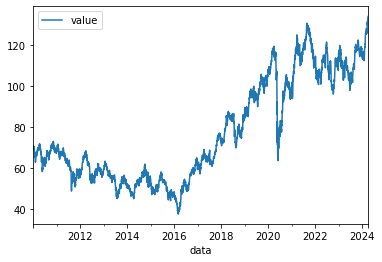

In [52]:
data.plot()

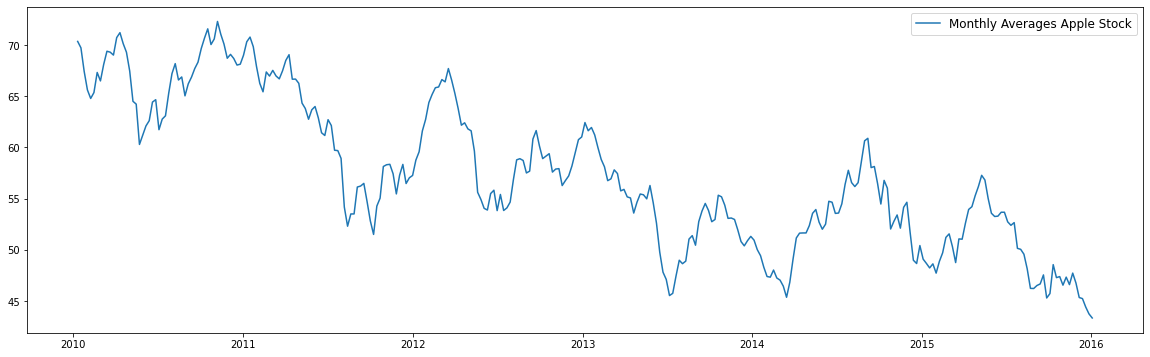

In [807]:
weakly_mean = data['value'].resample('W').mean()
data = weakly_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(data['value'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

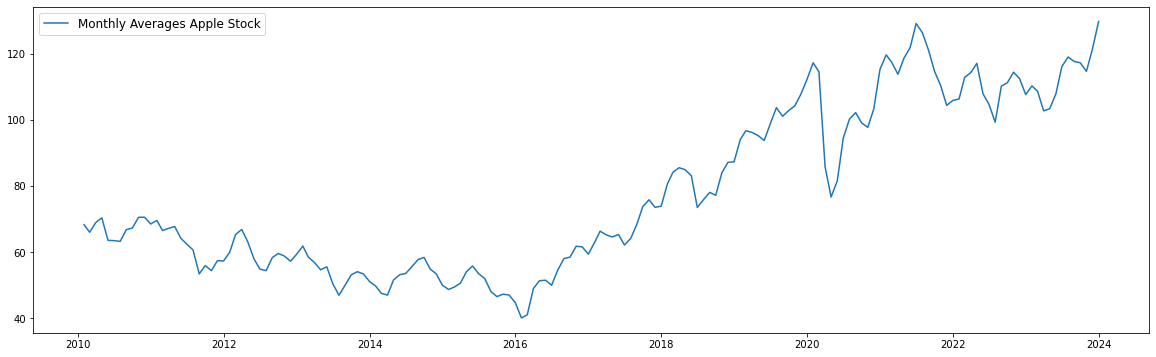

In [288]:
monthly_mean = data['value'].resample('M').mean()
data = monthly_mean.to_frame()
##Monthly Stock Price 
fig = plt.figure(figsize=(20,6))
plt.plot(data['value'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

In [53]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(0,1))
data = scale.fit_transform(data)

In [54]:
x,y = create_data(data,entradas)

In [55]:
# convert the x and y values into arrays
x, y = np.asarray(x), np.asarray(y)

In [56]:
x.reshape(-1,entradas).shape

(5191, 10)

In [57]:
train_x,train_y, test_x, test_y = split_data(x,y,percentual)

In [58]:
# convert the data from numpy to tensor
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_y = torch.from_numpy(test_y.astype(np.float32))

Total Possible Models 1
Epoch :0.0125    Train Loss :0.03173252195119858    Test Loss :0.18288865685462952
Epoch :0.025    Train Loss :0.013520975597202778    Test Loss :0.020962709560990334
Epoch :0.0375    Train Loss :0.02188006043434143    Test Loss :0.11217521876096725
Epoch :0.05    Train Loss :0.01815456710755825    Test Loss :0.033630646765232086
Epoch :0.0625    Train Loss :0.007736272644251585    Test Loss :0.04105750843882561
Epoch :0.075    Train Loss :0.0066695683635771275    Test Loss :0.007642895914614201
Epoch :0.0875    Train Loss :0.002838218118995428    Test Loss :0.026816893368959427
Epoch :0.1    Train Loss :0.0022618197835981846    Test Loss :0.015083512291312218
Epoch :0.1125    Train Loss :0.0017893350450322032    Test Loss :0.00630083866417408
Epoch :0.125    Train Loss :0.0011306338710710406    Test Loss :0.01470019668340683
Epoch :0.1375    Train Loss :0.0011713480344042182    Test Loss :0.007706151809543371
Epoch :0.15    Train Loss :0.0011316945310682058    

C:\Users\alex\AppData\Local\Temp\ipykernel_3796\3119262964.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  100.0
RMSE: 23.272440153900124
MAE: 22.00986634214252
MAPE: 19.121427151047413
{'dropout_rate': 0.8, 'epochs': 400, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


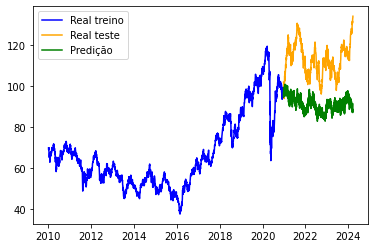

In [59]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2],
               'hid_size':[100],
              'lr': [0.01],
               'epochs':[400],
              'dropout_rate':[0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = y_pred
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])
plt.plot(datas['data'].iloc[:len(train_y_cp)],train_y_cp,label='Real treino', color = 'blue')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],test_y_cp,label='Real teste', color = 'orange')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],prediction_val,label='Predição',color = 'green')
#plt.axvline(int(len(x)*0.8),color='red')
plt.legend()

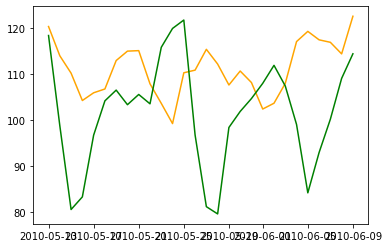

In [228]:
#plt.plot(datas['data'].iloc[:len(train_y_cp)],train_y_cp,label='Real treino', color = 'blue')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],test_y_cp,label='Real teste', color = 'orange')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],prediction_val,label='Predition',color = 'green')

Epoch :0.01    Train Loss :0.01861429587006569    Test Loss :0.17723213136196136
Epoch :0.02    Train Loss :0.01193243358284235    Test Loss :0.25457316637039185
Epoch :0.03    Train Loss :0.009923559613525867    Test Loss :0.19284014403820038
Epoch :0.04    Train Loss :0.008962872438132763    Test Loss :0.12565907835960388
Epoch :0.05    Train Loss :0.00577475456520915    Test Loss :0.0962563306093216
Epoch :0.06    Train Loss :0.0015596471494063735    Test Loss :0.010005585849285126
Epoch :0.07    Train Loss :0.0008004165138117969    Test Loss :0.001729213516227901
Epoch :0.08    Train Loss :0.0009112193947657943    Test Loss :0.004989201668649912
Epoch :0.09    Train Loss :0.0004987037973478436    Test Loss :0.002247923519462347
Epoch :0.1    Train Loss :0.00037238880759105086    Test Loss :0.0011634360998868942
Epoch :0.11    Train Loss :0.0001357675646431744    Test Loss :0.0031108807306736708
Epoch :0.12    Train Loss :0.0002369032590650022    Test Loss :0.0038666564505547285
Epo

Epoch :0.98    Train Loss :7.148149597924203e-05    Test Loss :0.000237844287767075
Epoch :0.99    Train Loss :7.116144115570933e-05    Test Loss :0.00023540810798294842
Epoch :1.0    Train Loss :7.084951357683167e-05    Test Loss :0.0002331357536604628
RMSE: 11.912035518716857
MAE: 9.461597080171536
MAPE: 8.730951254942683%
total:  50.0
RMSE: 11.912035518716857
MAE: 9.461597080171536
MAPE: 8.730951254942683
{'batch_size': 1, 'dropout_rate': 0.0, 'epochs': 500, 'hid_size': 170, 'lr': 0.01, 'num_layers': 1}


C:\Users\alex\AppData\Local\Temp\ipykernel_1888\101669459.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


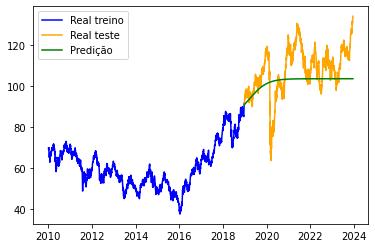

In [705]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

#{'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 500, 'hid_size': 200, 'lr': 0.01, 'num_layers': 1}

lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = 50,
            out_dim = x.shape[-1],
            dropout_rate= 0.0,
            num_layers = 1)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=500)


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')

if RMSE < best_rmse:
    best_rmse = RMSE
    best_mae = MAE
    best_mape = MAPE
    best_prediction = y_pred

model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
count += 1
print("total: " ,round(count/cnt,2)*100)

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])
plt.plot(datas['data'].iloc[:len(train_y_cp)],train_y_cp,label='Real treino', color = 'blue')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],test_y_cp,label='Real teste', color = 'orange')
plt.plot(datas['data'].iloc[len(train_y_cp):len(train_y_cp)+len(test_y_cp)],prediction_val,label='Predição',color = 'green')
#plt.axvline(int(len(x)*0.8),color='red')
plt.legend()

In [ ]:
import torch
import torch.nn as nn

# Suponha que você queira prever os próximos 10 passos de tempo
num_steps = 10

# Modifique seus dados de treinamento para refletir isso
x, y = [], []
for i in range(len(data) - num_steps):
    x.append(data[i:i+num_steps])
    y.append(data[i+1:i+num_steps+1])
    
train_x,train_y, test_x, test_y = split_data(x,y,0.8)

train_x = torch.tensor(train_x, dtype=torch.float)
train_y = torch.tensor(train_y, dtype=torch.float)
test_x = torch.tensor(test_x, dtype=torch.float)
test_y = torch.tensor(test_y, dtype=torch.float)

# Defina seu modelo LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, feature_dim, num_layers, num_steps):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, num_steps * feature_dim)
        self.feature_dim = feature_dim
        self.num_steps = num_steps

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(x.size(0), self.num_steps, self.feature_dim)


# Instancie o modelo
#lstm = LSTM(in_dim=train_x.shape[-1], hid_dim=5, feature_dim=train_x.shape[-1], num_layers=3)
lstm = LSTM(in_dim=train_x.shape[-1], hid_dim=5, feature_dim=train_x.shape[-1], num_layers=3, num_steps=num_steps)
# Defina a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters())

# Treine o modelo
for epoch in range(100):  # número de épocas
    lstm.train()
    optimizer.zero_grad()
    outputs = lstm(train_x)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Durante a inferência, você pode alimentar o modelo com uma sequência de `num_steps` passos de tempo
# e ele irá prever os próximos `num_steps` passos de tempo de uma vez
lstm.eval()
prediction_val = lstm(test_x)


In [189]:
import matplotlib.pyplot as plt
# Converta a saída do tensor PyTorch para um array NumPy
# plot the result
train_y_cp = scale.inverse_transform(np.asarray(train_y[0]).reshape(-1,1))
test_y_cp = scale.inverse_transform(np.asarray(test_y[0]).reshape(-1,1))
prediction_val_cp = scale.inverse_transform(np.asarray(prediction_val[0].detach().numpy()).reshape(-1,1))
data_cp = scale.inverse_transform(np.asarray(data).reshape(-1,1))



In [160]:
train_y_cp = np.asarray(train_y[-1]).reshape(-1,1)
test_y_cp = np.asarray(test_y[-1]).reshape(-1,1)
data_cp = data

In [190]:
prediction_val_cp

array([[ 52.577587 ],
       [ 75.34177  ],
       [ 64.56846  ],
       [ 74.570885 ],
       [ 68.47082  ],
       [ 67.576416 ],
       [ 67.779175 ],
       [ 76.37376  ],
       [ 68.07785  ],
       [ 35.86038  ],
       [ 28.88093  ],
       [ 68.988304 ],
       [ 80.360085 ],
       [ 51.232994 ],
       [ 67.61011  ],
       [ 68.16122  ],
       [ 50.49556  ],
       [ 80.45557  ],
       [ 68.29851  ],
       [ 64.70509  ],
       [ 36.38353  ],
       [ 69.84884  ],
       [ 58.74419  ],
       [ 68.21084  ],
       [ 68.129974 ],
       [ 59.20064  ],
       [ 47.81357  ],
       [ 67.078445 ],
       [ 75.09762  ],
       [ 61.1828   ],
       [ 59.07162  ],
       [ 24.03544  ],
       [ 41.10042  ],
       [ 63.390705 ],
       [ 79.346985 ],
       [ 61.577393 ],
       [ 70.281235 ],
       [ 51.245113 ],
       [ 72.65294  ],
       [ 67.40604  ],
       [ 25.382294 ],
       [ 80.27316  ],
       [ 66.75804  ],
       [ 81.572296 ],
       [ 17.918653 ],
       [ -

In [139]:
data = scale.inverse_transform(np.asarray(data).reshape(-1,1))

In [685]:
# implement GRU
class GRU(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layer):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.gru = nn.GRU(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initalize the hidden layers
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        out, _ = self.gru(x,h0)
        out = self.fc(out[:,-1,:])
        return out

In [691]:
# define the network
in_size = x.shape[-1]
out_size = in_size
hid_size = 60
num_layers =1

gru = GRU(in_size,hid_size,out_size, num_layers)

optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)
loss_fun = nn.MSELoss()

In [692]:
train_loss, test_loss = train_model(gru,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=500)

Epoch :0.01    Train Loss :0.021962763741612434    Test Loss :0.30210232734680176
Epoch :0.02    Train Loss :0.011096998117864132    Test Loss :0.12744174897670746
Epoch :0.03    Train Loss :0.00758646335452795    Test Loss :0.16319875419139862
Epoch :0.04    Train Loss :0.005451171658933163    Test Loss :0.0900878831744194
Epoch :0.05    Train Loss :0.0024549849331378937    Test Loss :0.01755501888692379
Epoch :0.06    Train Loss :0.00029868545243516564    Test Loss :0.022898510098457336
Epoch :0.07    Train Loss :0.0006662888918071985    Test Loss :0.0003249711880926043
Epoch :0.08    Train Loss :0.000270019838353619    Test Loss :0.006337831262499094
Epoch :0.09    Train Loss :0.00029022875241935253    Test Loss :0.00353198847733438
Epoch :0.1    Train Loss :0.00010807515354827046    Test Loss :0.0012068354990333319
Epoch :0.11    Train Loss :0.0001690733915893361    Test Loss :0.0009154008002951741
Epoch :0.12    Train Loss :0.00013641173427458853    Test Loss :0.000315076642436906

Epoch :0.98    Train Loss :4.9692393076838925e-05    Test Loss :0.00015829478797968477
Epoch :0.99    Train Loss :4.957755299983546e-05    Test Loss :0.0001580602693138644
Epoch :1.0    Train Loss :4.946500121150166e-05    Test Loss :0.00015783141134306788


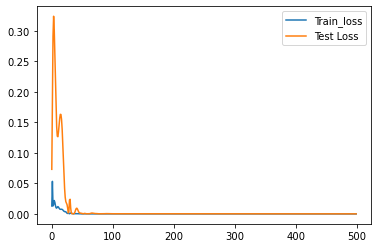

In [693]:
plt.plot(train_loss,label='Train_loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()

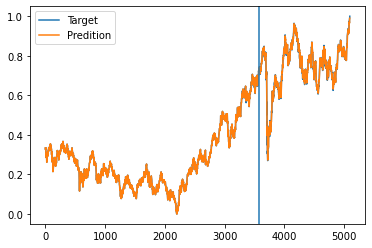

In [694]:
# testing the prediction quality if the trained model
# 1) Multi Step prediction
#plt.plot(train_y.detach().numpy())
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),gru(test_x).detach().numpy())),label='Predition')
plt.axvline(int(len(x)*0.7))
plt.legend()

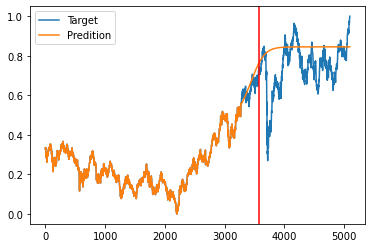

In [695]:
# testing the predction model on multiple time series
last_x = train_x[-1].view(10)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = gru(last_x.view(1,10,1))
    prediction_val.append(prediction[0,0].item())
    
    
    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))
    
# plot the result
plt.plot(np.vstack((train_y.detach().numpy(),test_y.detach().numpy())),label='Target')
plt.plot(np.vstack((train_y.detach().numpy(),np.asarray(prediction_val).reshape(-1,1))),label='Predition')
plt.axvline(int(len(x)*0.7),color='red')
plt.legend()